### On May 15, 2024, Ubisoft presented a trailer for a new game in the Assassin's Creed franchise. As of June 26, 2024, the trailer had collected almost 9 million views and almost 90 thousand comments and was received ambiguously by the audience. Therefore, it would be interesting to study the reaction of viewers using NLP methods. 

### Setup 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import translators as ts
from deep_translator import GoogleTranslator
from nltk.tokenize import word_tokenize
import re
from bs4 import BeautifulSoup
import contractions
import string
from unidecode import unidecode
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import gensim.corpora as corpora

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nik-g\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Download data from Youtube using Google Youtube API

In [70]:
# -*- coding: utf-8 -*-

import os
import googleapiclient.discovery
import csv

from conf import DEVELOPER_KEY, VIDEO_ID

# Function to download top-level comments
def youtube(nextPageToken=None):
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"    

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    request = youtube.commentThreads().list(
        part="id,snippet",
        maxResults=100,
        pageToken=nextPageToken,
        videoId=VIDEO_ID
    )
    response = request.execute()
    return response

# Function to download replies to comments
def youtubechild(NextParentId, nextPageToken=None):
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    request = youtube.comments().list(
        part="id,snippet",
        maxResults=100,
        pageToken=nextPageToken,
        parentId=NextParentId
    )
    response = request.execute()
    return response

# Main function
def main():
    # Download comments
    print('Downloading comments')
    response = youtube()
    items = response.get("items")
    nextPageToken = response.get("nextPageToken")  # downloaded in portions, each next portion is indicated by a token
    i = 1
    while nextPageToken is not None:
        print(str(i * 100))  # display which hundred comments are being downloaded
        response = youtube(nextPageToken)
        nextPageToken = response.get("nextPageToken")
        items = items + response.get("items")
        i += 1

    print(len(items))  # Display the number of downloaded comments

    # Download replies to comments
    print('Downloading replies')
    replies = []
    for line in items:  # Loop through top-level comments
        if line.get("snippet").get("totalReplyCount") > 0:  # if there are replies
            print(line.get("snippet").get("totalReplyCount"))  # display how many replies will be downloaded
            response = youtubechild(line.get("snippet").get("topLevelComment").get("id"))
            replies = replies + response.get("items")
            nextPageToken = response.get("nextPageToken")
            i = 1
            while nextPageToken is not None:  # load more replies if there are more portions
                response = youtubechild(line.get("snippet").get("topLevelComment").get("id"), nextPageToken)
                nextPageToken = response.get("nextPageToken")
                replies = replies + response.get("items")
                i += 1

    print(len(replies))  # Display the number of downloaded replies

    # Save comments and replies to a CSV file
    print("Opening CSV file")
    with open('youtuberesults.csv', 'w', encoding="utf-8") as csv_file:  # with statement to automatically close the file after all commands
        writer = csv.writer(csv_file, quoting=csv.QUOTE_ALL, lineterminator='\r')  # using double quotes and comma separator, this format opens well in LibreOffice Calc

        # Column headers
        row = [
            'etag',
            'parentid',
            'id',
            'textDisplay',
            'textOriginal',
            'authorDisplayName',
            'authorProfileImageUrl',
            'authorChannelUrl',
            'authorChannelId',
            'likeCount',
            'publishedAt',
            'updatedAt'
        ]
        print("Starting to write to CSV")  
        writer.writerow(row)  # Write headers to the file
    
        # Save comments
        print("Writing comments to CSV")  
        for line in items:
            topLevelComment = line.get("snippet").get("topLevelComment")
            # sometimes the user does not have a channel, so a separate construction for that
            if topLevelComment.get('snippet').get('authorChannelId') is not None:
                authorChannelId = topLevelComment.get('snippet').get('authorChannelId').get('value')
            else:
                authorChannelId = ''
            row = [
                topLevelComment.get('etag'),
                topLevelComment.get('id'),
                topLevelComment.get('id'),
                topLevelComment.get('snippet').get('textDisplay'),
                topLevelComment.get('snippet').get('textOriginal'),
                topLevelComment.get('snippet').get('authorDisplayName'),
                topLevelComment.get('snippet').get('authorProfileImageUrl'),
                topLevelComment.get('snippet').get('authorChannelUrl'),
                authorChannelId,
                topLevelComment.get('snippet').get('likeCount'),
                topLevelComment.get('snippet').get('publishedAt'),
                topLevelComment.get('snippet').get('updatedAt')
            ]
            writer.writerow(row)

        # Save replies
        print("Writing replies to CSV")  
        for line in replies:
            # sometimes the user does not have a channel, so a separate construction for that
            if line.get('snippet').get('authorChannelId') is not None:
                authorChannelId = line.get('snippet').get('authorChannelId').get('value')
            else:
                authorChannelId = ''
            row = [
                line.get('etag'),
                line.get('snippet').get('parentId'),
                line.get('id'),
                line.get('snippet').get('textDisplay'),
                line.get('snippet').get('textOriginal'),
                line.get('snippet').get('authorDisplayName'),
                line.get('snippet').get('authorProfileImageUrl'),
                line.get('snippet').get('authorChannelUrl'),
                authorChannelId,
                line.get('snippet').get('likeCount'),
                line.get('snippet').get('publishedAt'),
                line.get('snippet').get('updatedAt')
            ]
            writer.writerow(row)
        
    print("Done")  

if __name__ == "__main__":
    main()

100
200
300
400
500
600
700
800
900
974
1
1
57
4
1
1
1
1
1
6
1
1
4
6
1
5
1
13
2
1
1
1
2
2
2
1
3
8
1
4
1
1
2
7
9
8
3
1
1
1
1
1
5
1
1
4
5
8
8
4
10
4
3
9
2
3
3
2
2
5
13
3
3
1
2
6
1
2
4
3
1
1
1
1
1
1
5
12
1
1
1
2
1
30
15
2
1
1
1
2
3
1
1
1
3
1
1
7
1
3
1
7
1
1
43
3
1
4
17
5
307
1
7
3
2
3
1
1
39
1
1
17
1
34
1
4
2
11
5
1
1
1
2
4
1
1
21
2
9
11
8
5
1
2
1
6
1
1
7
1
4
3
1
5
7
1
2
8
6
2
56
3
5
2
5
12
20
14
6
4
3
6
12
1
3
1
2
17
2
9
1
44
2
20
1
1
1
38
5
5
5
16
17
19
1
27
31
1457
Opening CSV file
Starting to write to CSV
Writing comments to CSV
Writing replies to CSV
Done


### Data reading

In [7]:
df = pd.read_csv("youtuberesults.csv")

In [8]:
df.head()

,etag,parentid,id,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,likeCount,publishedAt,updatedAt
0,GAHOn0yRQmSARotP8rNS2_ZdlXY,UgxY_z0f0WtfmarscaR4AaABAg,UgxY_z0f0WtfmarscaR4AaABAg,Honestly<br>What&#39;s you guys problem<br>The...,Honestly\r\nWhat's you guys problem\r\nThey ad...,@Person-mr3cy,https://yt3.ggpht.com/d12LCwUgD7xIGr2hB_adl25F...,http://www.youtube.com/@Person-mr3cy,UCgDw1YWBh9Cn_v4WXBlIwNg,0,2024-06-24T08:34:32Z,2024-06-24T08:34:32Z
1,EaztDwMFUfjxWCBdC9EVBxpjLGk,Ugxor3ZZ9oZvnYl1GeJ4AaABAg,Ugxor3ZZ9oZvnYl1GeJ4AaABAg,全てこのゲームのお陰。<br>もうアサシンシリーズ卒業します。<br>今までありがとうござい...,全てこのゲームのお陰。\r\nもうアサシンシリーズ卒業します。\r\n今までありがとうござい...,@user-mw7li1co4d,https://yt3.ggpht.com/ytc/AIdro_laRl6quGL1gQNI...,http://www.youtube.com/@user-mw7li1co4d,UCwDZ4FRMVQHXtOKwPLaA4dQ,0,2024-06-24T07:37:14Z,2024-06-24T07:37:14Z
2,jR9p_eIpaDaSIAFsXSiR5jgp_34,UgyOk3DSzy0szL7akSl4AaABAg,UgyOk3DSzy0szL7akSl4AaABAg,日本の予約順位 <br>1位 ドラゴンクエスト 11/14<br><br>21位 アサシン...,日本の予約順位 \r\n1位 ドラゴンクエスト 11/14\r\n\r\n21位 アサシン...,@user-gr7uh4vq2u,https://yt3.ggpht.com/ytc/AIdro_k5h6IwS5GKf8s3...,http://www.youtube.com/@user-gr7uh4vq2u,UC0vEqYguZqulaA-5tlsASFA,0,2024-06-24T06:05:42Z,2024-06-24T06:05:42Z
3,qWAW1h_vYkb9G1-qpGyJbUjis4s,UgwPUVw6DKtifRv6AjV4AaABAg,UgwPUVw6DKtifRv6AjV4AaABAg,I love how 90% of the comments from these “Jap...,I love how 90% of the comments from these “Jap...,@AndrewSelden,https://yt3.ggpht.com/ytc/AIdro_ka_OJb0XNJYDEo...,http://www.youtube.com/@AndrewSelden,UCizQwXVk57A4JS8Ns7EWujw,0,2024-06-24T04:55:58Z,2024-06-24T04:55:58Z
4,whl_8Cwc6cqZZLDBN_VylmPMFQg,UgwhD0JcKS1Jw83jCcB4AaABAg,UgwhD0JcKS1Jw83jCcB4AaABAg,Just look at the Female Assassin game-play? TH...,Just look at the Female Assassin game-play? TH...,@RawLu.,https://yt3.ggpht.com/ZD2h-nMNVQW9PAzU4WLWCtXe...,http://www.youtube.com/@RawLu.,UC_jS_pKSqzAfHW37Hj5HaQg,0,2024-06-24T01:57:45Z,2024-06-24T01:57:45Z


In [9]:
df = df[['textDisplay', 'textOriginal', 'authorDisplayName', 'likeCount', 'publishedAt']]

In [10]:
df.head()

,textDisplay,textOriginal,authorDisplayName,likeCount,publishedAt
0,Honestly<br>What&#39;s you guys problem<br>The...,Honestly\r\nWhat's you guys problem\r\nThey ad...,@Person-mr3cy,0,2024-06-24T08:34:32Z
1,全てこのゲームのお陰。<br>もうアサシンシリーズ卒業します。<br>今までありがとうござい...,全てこのゲームのお陰。\r\nもうアサシンシリーズ卒業します。\r\n今までありがとうござい...,@user-mw7li1co4d,0,2024-06-24T07:37:14Z
2,日本の予約順位 <br>1位 ドラゴンクエスト 11/14<br><br>21位 アサシン...,日本の予約順位 \r\n1位 ドラゴンクエスト 11/14\r\n\r\n21位 アサシン...,@user-gr7uh4vq2u,0,2024-06-24T06:05:42Z
3,I love how 90% of the comments from these “Jap...,I love how 90% of the comments from these “Jap...,@AndrewSelden,0,2024-06-24T04:55:58Z
4,Just look at the Female Assassin game-play? TH...,Just look at the Female Assassin game-play? TH...,@RawLu.,0,2024-06-24T01:57:45Z


### Date extraction

In [11]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [12]:
df['date'] = df['publishedAt'].dt.date

In [13]:
comment_counts = df['date'].value_counts().sort_index()

In [10]:
print(comment_counts)

date
2024-06-10    637
2024-06-11    627
2024-06-12    296
2024-06-13    179
2024-06-14     67
2024-06-15     31
2024-06-16     82
2024-06-17    134
2024-06-18     82
2024-06-19     47
2024-06-20     47
2024-06-21     36
2024-06-22     31
2024-06-23     66
2024-06-24     69
Name: count, dtype: int64


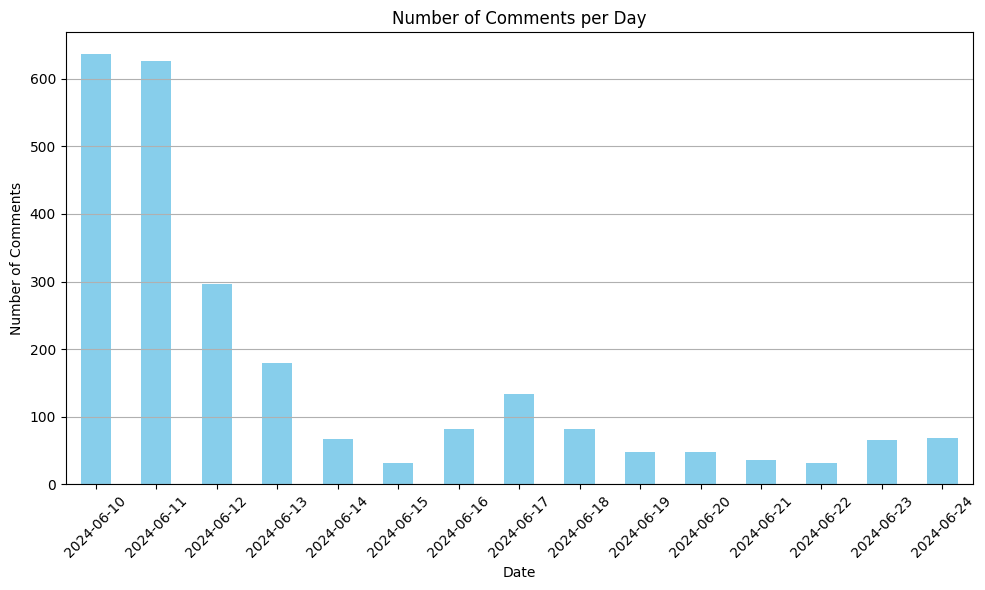

In [14]:
plt.figure(figsize=(10, 6))
comment_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Comments per Day')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

The graph shows that the number of comments decreases over time. This is quite natural. </p> These comments seem normal enough. 

### Data translation 

As we can see, the comments are written in different languages. Let's translate them into English

In [3]:
# Translate comments to English
def translate_comment(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text=text)
    except Exception as e:
        return text  # Return the original text if translation fails

In [4]:
df_test = df.head(10)

NameError: name 'df' is not defined

In [6]:
df['textOriginalTranslated'] = df['textOriginal'].apply(translate_comment)

NameError: name 'df' is not defined

In [ ]:
df.to_csv('df_translated.csv', index=False)

In [5]:
df = pd.read_csv('df_translated.csv')

In [6]:
df.head()

,textDisplay,textOriginal,authorDisplayName,likeCount,publishedAt,date,textOriginalTranslated
0,Honestly<br>What&#39;s you guys problem<br>The...,Honestly\r\nWhat's you guys problem\r\nThey ad...,@Person-mr3cy,0,2024-06-24 08:34:32+00:00,2024-06-24,Honestly\r\nWhat's you guys problem\r\nThey ad...
1,全てこのゲームのお陰。<br>もうアサシンシリーズ卒業します。<br>今までありがとうござい...,全てこのゲームのお陰。\r\nもうアサシンシリーズ卒業します。\r\n今までありがとうござい...,@user-mw7li1co4d,0,2024-06-24 07:37:14+00:00,2024-06-24,It's all thanks to this game. \nI'm graduating...
2,日本の予約順位 <br>1位 ドラゴンクエスト 11/14<br><br>21位 アサシン...,日本の予約順位 \r\n1位 ドラゴンクエスト 11/14\r\n\r\n21位 アサシン...,@user-gr7uh4vq2u,0,2024-06-24 06:05:42+00:00,2024-06-24,Pre-order ranking in Japan \n\n1st place: Drag...
3,I love how 90% of the comments from these “Jap...,I love how 90% of the comments from these “Jap...,@AndrewSelden,0,2024-06-24 04:55:58+00:00,2024-06-24,I love how 90% of the comments from these “Jap...
4,Just look at the Female Assassin game-play? TH...,Just look at the Female Assassin game-play? TH...,@RawLu.,0,2024-06-24 01:57:45+00:00,2024-06-24,Just look at the Female Assassin game-play? TH...


In [11]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].str.replace(r'<br>|\r|\n', ' ', regex=True)

In [12]:
df['textOriginalTranslated'].head()

0    Honestly  What's you guys problem  They add de...
1    It's all thanks to this game.  I'm graduating ...
2    Pre-order ranking in Japan   1st place: Dragon...
3    I love how 90% of the comments from these “Jap...
4    Just look at the Female Assassin game-play? TH...
Name: textOriginalTranslated, dtype: object

Lower casing

In [13]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].str.lower()

Expand contractions

In [14]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].astype(str).apply(
    lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x.split()]))

Remove html tags

In [15]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].astype(str).apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

C:\Users\nik-g\AppData\Local\Temp\ipykernel_5488\663498864.py:1: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['textOriginalTranslated'] = df['textOriginalTranslated'].astype(str).apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
C:\Users\nik-g\AppData\Local\Temp\ipykernel_5488\663498864.py:1: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  df['textOriginalTranslated'] = df['textOriginalTranslated'].astype(str).apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


In [16]:
print(df['textOriginalTranslated'])

0       honestly what is you guys problem they add dem...
1       it is all thanks to this game. i am graduating...
2       pre-order ranking in japan 1st place: dragon q...
3       i love how 90% of the comments from these “jap...
4       just look at the female assassin game-play? th...
                              ...                        
2426    @@adam-xe1od "get good" when the ai detection ...
2427          @@jojo-nq3bp proving my point, get good🤷‍♂️
2428        why do nagas take pleasure in killing asians?
2429                           ​@@adam-xe1oduseless troll
2430    @the_seer_0421 not a troll, you just cannot fa...
Name: textOriginalTranslated, Length: 2431, dtype: object


Remove numbers

In [17]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].apply(lambda x: re.sub(r'\d+', '', x))

Replace dots with spaces

In [18]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].apply(lambda x: re.sub("[.]", " ", x))

Remove punctuations

In [19]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

Get rid of double spaces

In [20]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].apply(lambda x: re.sub(' +', ' ', x))

Replace diacritics

In [21]:
df['textOriginalTranslated'] = df['textOriginalTranslated'].apply(lambda x: unidecode(x, errors="preserve"))

Remove Stopwords

In [22]:
nltk.download("stopwords")
sw_nltk = stopwords.words('english')
# stopwords customaization: Add custom stopwords
new_stopwords = ['cowboy']
sw_nltk.extend(new_stopwords)
# stopwords customaization: Remove already existing stopwords
sw_nltk.remove('not')
text_col = df['textOriginalTranslated'].apply(
    lambda x: " ".join([ word for word in x.split() if word not in sw_nltk]) )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nik-g\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatization

In [23]:
lemmatizer = WordNetLemmatizer()
df['textOriginalTranslated'] = df['textOriginalTranslated'].apply(lambda x: lemmatizer.lemmatize(x))

In [24]:
import torch
import transformers
from transformers import (BertTokenizer,  # For BERT tokenizer
    AutoTokenizer,  # For automatic selection of tokenizer
    BertForSequenceClassification,  # For BERT-based sequence classification model
    AdamW,  # For AdamW optimizer
    get_linear_schedule_with_warmup)  # For learning rate scheduling

# Importing necessary classes from torch.utils.data for handling datasets
from torch.utils.data import (TensorDataset, DataLoader, 
                              RandomSampler, SequentialSampler)

c:\Users\nik-g\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
df['textOriginalTranslated'].head(100)

0     honestly what is you guys problem they add dem...
1     it is all thanks to this game i am graduating ...
2     preorder ranking in japan st place dragon ques...
3     i love how of the comments from these "japanes...
4     just look at the female assassin gameplay that...
                            ...                        
95    ubi is a terrible company discriminating again...
96    i am fed up with the for honor gameplay it is ...
97    this is already a high level of racism towards...
98                                      no more ubisoft
99    this game needs to be handed over to a japanes...
Name: textOriginalTranslated, Length: 100, dtype: object

In [26]:
# Join the different processed titles together.
long_string = ','.join(list(df['textOriginalTranslated'].values))

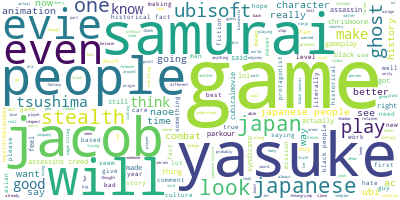

In [27]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Sentiment analysis

In [30]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def analyze_sentiment(text):
    return analyzer.polarity_scores(text)

# Apply the sentiment analysis to each entry in 'textOriginalTranslated'
df['sentiment_scores'] = df['textOriginalTranslated'].apply(analyze_sentiment)

# Print the DataFrame with the sentiment scores
print(df)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nik-g\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                            textDisplay  \
0     Honestly<br>What&#39;s you guys problem<br>The...   
1     全てこのゲームのお陰。<br>もうアサシンシリーズ卒業します。<br>今までありがとうござい...   
2     日本の予約順位　<br>1位　ドラゴンクエスト  11/14<br><br>21位　アサシン...   
3     I love how 90% of the comments from these “Jap...   
4     Just look at the Female Assassin game-play? TH...   
...                                                 ...   
2426  @@Adam-xe1od &quot;get good&quot; when the ai ...   
2427        @@Jojo-nq3bp Proving my point, get good🤷‍♂️   
2428      Why do Nagas take pleasure in killing Asians?   
2429                         ​@@Adam-xe1oduseless troll   
2430  @the_seer_0421  Not a troll, you just can&#39;...   

                                           textOriginal  authorDisplayName  \
0     Honestly\r\nWhat's you guys problem\r\nThey ad...      @Person-mr3cy   
1     全てこのゲームのお陰。\r\nもうアサシンシリーズ卒業します。\r\n今までありがとうござい...   @user-mw7li1co4d   
2     日本の予約順位　\r\n1位　ドラゴンクエスト  11/14\r\n\r\n21位　アサシン...  

Function to classify sentiment based on compound score

In [31]:
def classify_sentiment(scores):
    compound = scores['compound']
    if compound <= -0.05:
        return 'negative'
    elif compound >= 0.05:
        return 'positive'
    else:
        return 'neutral'

# Apply classification to each sentiment score
df['sentiment'] = df['sentiment_scores'].apply(classify_sentiment)

# Calculate statistics
sentiment_counts = df['sentiment'].value_counts()

# Print the sentiment statistics
print(sentiment_counts)

sentiment
positive    1015
negative     901
neutral      515
Name: count, dtype: int64


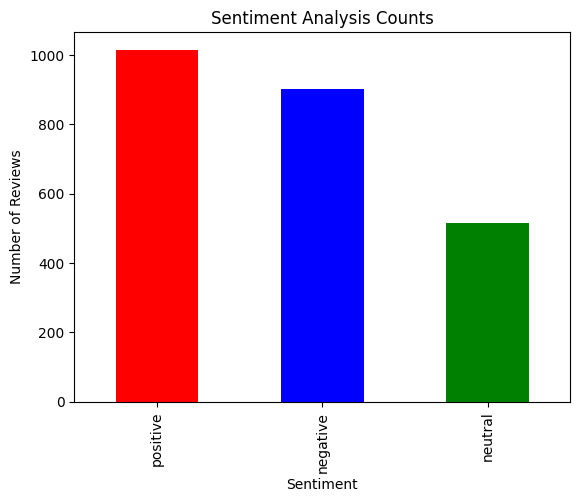

In [32]:
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment Analysis Counts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()